In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import tensorflow_addons as tfa

In [3]:
import numpy as np

In [4]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

In [5]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [6]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        # Same padding makes input size and output size at the same
        # only if strides was 1 ... (I-1)/S + 1
        # Same padding P is (K-1)/2
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [7]:
monet_generator = Generator()
photo_generator= Generator()
monet_generator_150=Generator()

In [8]:
monet_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

In [9]:
monet_generator.load_weights('m_gen.hdf5')
photo_generator.load_weights('p_gen.hdf5')
monet_generator_150.load_weights('m_gen_150.hdf5')

In [10]:
img=tf.keras.preprocessing.image.load_img('test_1.jpg')

In [11]:
def decode(image):
    image=(image/127.5)-1
    return image

In [12]:
img_tensor = tf.convert_to_tensor(img,dtype=tf.float32)

In [13]:
decoded=decode(img_tensor)

In [14]:
model_inp=tf.expand_dims(decoded, 0)

In [31]:
prediction=monet_generator(model_inp, training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

prediction_150_=monet_generator_150(model_inp,training=False)
prediction_150=prediction_150_[0].numpy()

rev_pred=photo_generator(prediction_150_,training=False)[0].numpy()
prediction_150= (prediction_150*127.5+127.5).astype(np.uint8)

rev_pred_dis=(rev_pred*127.5+127.5).astype(np.uint8)

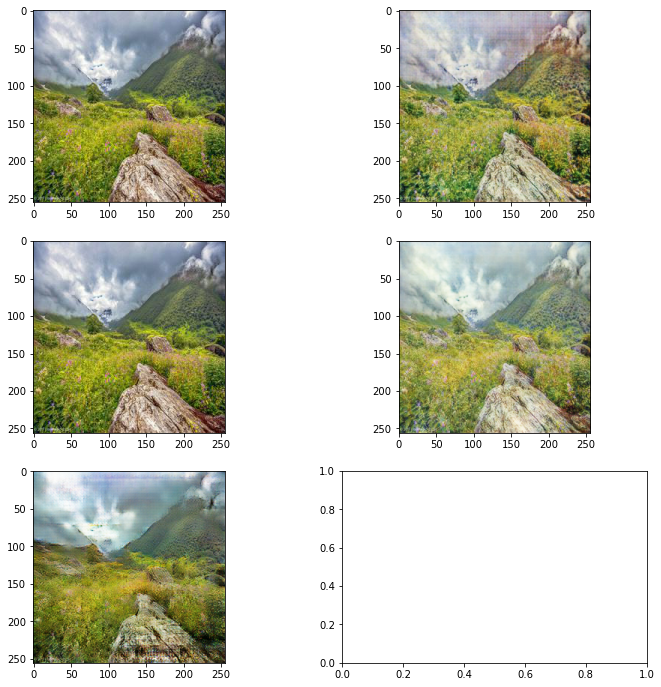

In [32]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(img)
ax[0, 1].imshow(prediction)
ax[1, 0].imshow(img)
ax[1, 1].imshow(prediction_150)
ax[2, 0].imshow(rev_pred_dis)